# Постановка задачи

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. <br> 

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. <br>

Вам нужно построить модель для определения стоимости.

Ключевые аспекты построения модели:<br>
- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


%matplotlib inline

# Этап 1. Загрузка и подготовка данных.

In [2]:
path_review = '/datasets/autos.csv'
my_path = '/Users/Ideapad S145/Desktop/Data_Science/09.Численные методы/Практика/autos.csv'

if os.path.exists(path_review):
    df = pd.read_csv(path_review, sep=',')
elif os.path.exists(my_path):
    df = pd.read_csv(my_path, sep=',')
else:
    print("Проверьте правильность пути к датасету")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Всего в датасете 354 369 объектов с 16 признаками.<br>
Предварительно можно оценить, что датасет упорядочен по дате последнего посещения.<br>
**Далее, когда буду делить датасет на обучающую и тестовую выборку этот момент будет учтен.**


Признак (поле) VehicleType содержит 316 879 объектов с заполненными значениями  и 37 490 объектов с незаполненными значениями.<br>
Признак Gearbox содержит 334 536 объектов с заполненными значениями и 19 833 объекта с незаполненными значениями.<br>
Признак Model содержит 334 664 объектов с заполненными значениями и 19 705 объектов с незаполненными значениями.<br>
Признак FuelType содержит 321 474 объекта с заполненными значениями и 32 895 объектов с незаполненными значениями.<br>
Признак NotRepaired содержит 283 215 объекта с заполненными значениями и 71 154 объектов с незаполненными значениями.<br>

Не заполненные значения для отдельных признаков означает наличие ошибок в заполнении полей соответствующей формы. Это также означает, что могут быть объекты, у которых все признаки имеют заполненные значения, но они могут быть ошибочно заполненны.

Название бренда и название модели однозначно определяют тип кузова. Т.е. тип кузова это 100% зависимая величина от модели автомобиля. Поэтому этот столбец можем спокойно удалить.

In [5]:
df = df.drop('VehicleType', axis=1)

Название модели это базовый признак, по которому идентифицируется объект и цена на объект. Если нам неизвестна модель (значение NaN), то мы не сможем корректно обучить модель, т.к. название модели это ключевой признак. Поэтому удалим все строки со значением NaN в столбце Model

In [6]:
df.dropna(subset=['Model'], inplace=True)

Посмотрим сколько останется объектов после удаления

In [7]:
print(df.shape)

(334664, 15)


Осталось 334 664 объекта или 94% от размера исходного датасета.

Посмотрим сколько останется объектов, если из датасета удалить все объекты с пропусками.

In [8]:
print(df.dropna().shape)

(253906, 15)


Если удалить все объекты с пропущенными значениями, то в нашем датасете останется 253 906 записей или ~76% от размера датасета после удаления объектов с пропущенными значениями в поле Model.

Оставшиеся пропуски в признаках Gearbox, FuelType и NotRepaired предлагаю заменить значением missing values. Далее в анализе, если выяснится, что данные признаки обладают малым влиянием на предсказание, то их можно будет удалить 

In [9]:
df = df.fillna('missing values')

In [10]:
print('Количество дубликатов =', df.duplicated().sum())

Количество дубликатов = 4


Удалим дубликаты

In [11]:
df = df.drop_duplicates()

Посмотрим что получилось.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        334660 non-null  object
 1   Price              334660 non-null  int64 
 2   RegistrationYear   334660 non-null  int64 
 3   Gearbox            334660 non-null  object
 4   Power              334660 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          334660 non-null  int64 
 7   RegistrationMonth  334660 non-null  int64 
 8   FuelType           334660 non-null  object
 9   Brand              334660 non-null  object
 10  NotRepaired        334660 non-null  object
 11  DateCreated        334660 non-null  object
 12  NumberOfPictures   334660 non-null  int64 
 13  PostalCode         334660 non-null  int64 
 14  LastSeen           334660 non-null  object
dtypes: int64(7), object(8)
memory usage: 40.9+ MB


В итоге мы удалили очевидно избыточный столбец с типом кузова автомобиля, удалили пропуски в главном столбце признаков Model, заменили пропуски в столбцах признаках Gearbox, FuelType и NotRepaired, а также удалили все четыре дубликата.

Посмотрим структуру данных каждого признака.

**Признак DateCrawled (дата скачивания анкеты из базы)**

Переведем в значения поля в формат даты и времени.

In [13]:
df.DateCrawled = pd.to_datetime(df.DateCrawled, format='%Y-%m-%d %H:%M:%S')

In [14]:
print('Все объявления скачены из базы', min(df.DateCrawled), ' - ', max(df.DateCrawled))

Все объявления скачены из базы 2016-03-05 14:06:22  -  2016-04-07 14:36:58


Для построение модели этот признак DateCrawled с фундаментальной точки зрения смысла не имеет и поэтому его можно удалить из пространства признаков нашей модели.

In [15]:
df = df.drop('DateCrawled', axis=1)

**Признак DateCreated (дата создания анкеты)**

Переведем в значения поля в формат даты и времени.

In [16]:
df.DateCreated = pd.to_datetime(df.DateCreated, format='%Y-%m-%d %H:%M:%S')

In [17]:
print('Все объявления размещены в диапазоне', min(df.DateCreated), ' - ', max(df.DateCreated))

Все объявления размещены в диапазоне 2014-03-10 00:00:00  -  2016-04-07 00:00:00


Т.е. в течении почти двух лет. Таким образом, к влиянию на цену добавляются сезонность, инфляция, фактор выхода новых моделей и пр.

Предлагаю от признака DateCreated (дата создания анкеты) перейти к двум признакам - Год создания анкеты (YearCreated) и Месяц создания анкеты (MonthCreated).

In [18]:
df['YearCreated'] = df.DateCreated.dt.year
df['MonthCreated'] = df.DateCreated.dt.month

**Признак LastSeen (последнее посещение продавцом анкеты)**

Переведем в формат даты

In [19]:
df.LastSeen = pd.to_datetime(df.LastSeen, format='%Y-%m-%d %H:%M:%S')
print('Все визиты находятся в диапазоне', min(df.LastSeen), ' - ', max(df.LastSeen))

Все визиты находятся в диапазоне 2016-03-05 14:15:08  -  2016-04-07 14:58:51


В таком виде признак неинформативен и бесполезен. По пробуем первести его в числовой формат - сколько дней прошло с момента создания анкеты до последнего посещения продавца, а именно DaysLastSeen = LastSeen - DateCreated. Чем короче срок, тем быстрее машина продается, а значит цена авто справедлива, т.е. устраивает как продавца, так и покупателя.  

In [20]:
df['DaysLastSeen'] = (df.LastSeen - df.DateCreated).dt.days

Посмотрим, что получилось.

In [21]:
df[['DaysLastSeen', 'LastSeen', 'DateCreated']].head(3)

,DaysLastSeen,LastSeen,DateCreated
0,14,2016-04-07 03:16:57,2016-03-24
2,22,2016-04-05 12:47:46,2016-03-14
3,0,2016-03-17 17:40:17,2016-03-17


In [22]:
df['DaysLastSeen'].value_counts().sort_index()

0      47527
1      20009
2      36024
3      16840
4      25127
       ...  
239        1
244        1
292        1
384        1
759        1
Name: DaysLastSeen, Length: 108, dtype: int64

Так лучше будет.

Теперь мы модем удалить столбцы-признаки LastSeen и DateCreated.

In [23]:
df = df.drop(['LastSeen', 'DateCreated'], axis=1)

**Признак RegistrationMonth (месяц регистрации автомобиля)**

In [24]:
df.RegistrationMonth.value_counts().sort_index()

0     30810
1     22052
2     20419
3     33096
4     27984
5     27853
6     30105
7     25961
8     21692
9     22977
10    25107
11    23322
12    23282
Name: RegistrationMonth, dtype: int64

Месяц с нулевым значением - это какая-то ошибка заполнения анкеты. Заменить это значение через какое-то предположение нечем, поэтому удалим все объекты с нулевым значением приззнака месяц регистрации автомобиля.

In [25]:
df = df[df.RegistrationMonth != 0]

**Признак RegistrationYear (год регистрации автомобиля)**

Год регистрации автомобиля - это очень важный фактор влияющий на цену автомобиля и поэтому отнесемся к корректности заполненных значений данного признака у объектов датасета очень серьезно, т.к. это будет существенно влиять на качество модели. 

In [26]:
df.RegistrationYear.value_counts().sort_index()

1000    4
1400    1
1500    2
1600    1
1800    2
       ..
7000    2
7100    1
8200    1
9000    1
9999    2
Name: RegistrationYear, Length: 105, dtype: int64

Посмотрим сколько автомобилей с заявленным годом и месяцем регистрации большим года создания анкеты.

In [27]:
print('Количество анкет, у которых год регистрации автомобиля больше года создания анкеты = ', len(df[df.RegistrationYear > df.YearCreated]))

Количество анкет, у которых год регистрации автомобиля больше года создания анкеты =  9491


Это ошибки ввода. Поправить мы их не сможем и поэтому их придется удалить.

In [28]:
df = df[df.RegistrationYear <= df.YearCreated]

В нашем датасете есть также ошибки ввода в части сильного занижения года регистрации автомобиля. У нас не рынок раритетных автомобилей и поэтому все анкеты, у которых год регистрации будет явно ошибочен также удалим.

На основе экспертной оценки посмотрим, сколько автомобилей старше 10, 15, 20, 25 и 30 лет от даты регистрации автомобиля.

In [29]:
for i in [10, 15, 20, 25, 30]:
    print('Количество автомобилей старше', i, 'лет = ', 
          sum(df.RegistrationYear < (df.YearCreated - i)),
         'или', round(100*np.mean(df.RegistrationYear < (df.YearCreated - i)), 1), '%')


Количество автомобилей старше 10 лет =  190688 или 64.8 %
Количество автомобилей старше 15 лет =  100059 или 34.0 %
Количество автомобилей старше 20 лет =  26351 или 9.0 %
Количество автомобилей старше 25 лет =  8257 или 2.8 %
Количество автомобилей старше 30 лет =  3822 или 1.3 %


Автомобиль старше 20 лет в нашем датасете это либо ошибка заполнения либо редкий экземпляр, который подлежит скорее всего утилизации, если это не ретроавтомобиль. Но у нас площадка для продажи обычных автомобилей и поэтому удалим все анкеты, в которых указаны автомобили возрастом старше 20 лет.

In [30]:
df = df[df.RegistrationYear >= (df.YearCreated - 20)]

Хочется отметить, что само по себе год и дата регистрации существенные признаки, но еще более существенным признаком является возраст автомобиля на момент создания объявления. Если мы перейдем к данному признаку, то соответственно мы можем отказаться от признаков год и месяц регистрации автомобиля, а также год и месяц создания анкеты.

Предлагаю измерять возраст автомобиля в месяцах.

In [31]:
df['AgeAutoMonth'] = (df.YearCreated * 12 + df.MonthCreated) - (df.RegistrationYear * 12 + df.RegistrationMonth)

У нас должны остаться автомобили с отрицательным возрастов.

In [32]:
df[df.AgeAutoMonth < 0].AgeAutoMonth.value_counts()

-3    621
-2    611
-1    576
-7    525
-4    507
-6    473
-5    454
-8    449
-9    348
Name: AgeAutoMonth, dtype: int64

Удалим их.

In [33]:
df = df[df.AgeAutoMonth > 0]

Удалим теперь уже ненужные признаки RegistrationYear и RegistrationMonth. Признаки YearCreated и MonthCreated оставим, т.к. в них скрыто сидит сезонность, инфляция и обновление модели, но объединим их в один признак, переведя их в месяцы, и тем самым сократим пространство признаков.

In [34]:
df['CreatedInMonth'] = df.YearCreated * 12 + df.MonthCreated

df = df.drop(['RegistrationYear', 'RegistrationMonth', 'YearCreated', 'MonthCreated'], axis=1)

**Признак Gearbox (тип коробки передач)**

In [35]:
df.Gearbox.value_counts()

manual            203179
auto               52967
missing values      6701
Name: Gearbox, dtype: int64

Тип коробки передач это опция в автомобиле и поэтому одна и таже модель может быть как с автоматческой коробокй так и с ручной коробкой передач и строгого правила определения типа коробки передач нет. В связи с этим как-то подставить пропущенные значения на основании других признаков не представляется возможным. Учитывая малость объектов с пропущенными значениями типа коробки передач, предлагаю удалить подобные объекты.

In [36]:
df = df[df.Gearbox != 'missing values']

Переведем значения данного признака в числовой формат, сделав справочник manual = 0, auto = 1

In [37]:
df.loc[df.Gearbox == 'manual', 'Gearbox'] = 0
df.loc[df.Gearbox == 'auto', 'Gearbox'] = 1
df.Gearbox = df.Gearbox.astype('int')

In [38]:
Gearbox = pd.DataFrame([['manual', 0], ['auto', 1]], columns=['TypeGearbox', 'CodeGearbox'])
Gearbox

,TypeGearbox,CodeGearbox
0,manual,0
1,auto,1


**Признак Power (мощность дивгателя  в л. с.)**

In [39]:
df.Power.value_counts().sort_index()

0        12785
1           12
2            2
3            1
4            4
         ...  
17700        1
17932        1
19208        1
19312        1
20000        1
Name: Power, Length: 600, dtype: int64

Очевидно, что слишком большие и слишком маленькие значения мощности дивгателей - это ошибка заполнения формы. Правила исправления этой ошибки нам неизвестны. Посмотрим сколько данных с ошибками, например сколько объектов с мощностью больше 1000 л.с.

In [40]:
len(df[df.Power > 1000])

187

Немного подобных ошибок и поэтому их удалим. Кроме того, я посмотрел мощности разных марок и моделей в интернете и это однозначно ошибки

In [41]:
df = df[df.Power < 1000]

T.к. мощность двигателя зависит от объема двигателя, а объем двигателя это опять же опция в автомобиле (одна и таже марка может быть с разным объемом двигателя и соответственно разной мощностью), то мы не можем по какому-либо правилу восстановить реальные значения мощности двигателя относительно ошибочно введенных. В связи с этим все объекты с мощностью меньше 40 (экспертно взял порог) предлагаю удалить.

In [42]:
df = df[df.Power > 40]

In [43]:
df.Power.describe()

count    242782.000000
mean        123.478549
std          53.999125
min          41.000000
25%          82.000000
50%         116.000000
75%         150.000000
max         999.000000
Name: Power, dtype: float64

In [44]:
# напишем функцию, которая строила бы гистограмму распределения и ящик с усами
def distribution_feature(feature):
    fig = plt.figure(figsize=(12,4))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    sns.histplot(x=feature, kde=True, ax=ax_1)
    ax_2 = sns.boxplot(x=feature, ax=ax_2)
    ax_1.set_title(f'Гистограмма распределения признака {feature.name}', fontsize=12)
    ax_2.set_title(f'Ящик с усами {feature.name}', fontsize=12)

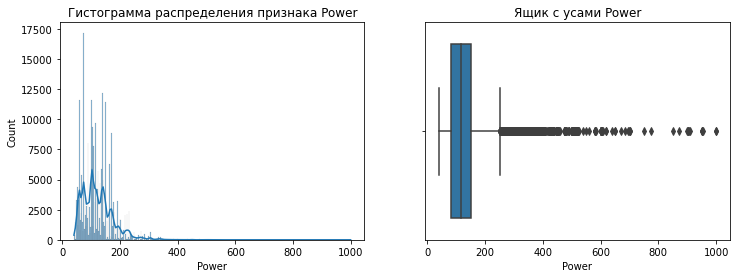

In [45]:
distribution_feature(df.Power)

После редактирования мы видим более-менее объяснимую картину, в которой основная масса автомобилей имеет мощность до 200 л.с., а все что справа это редкие мощные автомобили как правило премиального сегмента. А меньше 40 л.с. массовых автомобилей не бывает.

**Признак Kilometer (пробег в километрах)**

In [46]:
df.Kilometer.describe()

count    242782.000000
mean     127360.739264
std       36881.937086
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [47]:
print('доля автомобилей с пробегом 150 000 км =', round(len(df[df.Kilometer == 150_000])/len(df)*100), '%')

доля автомобилей с пробегом 150 000 км = 65 %


Посмотрим распределение автомобилей относительно пробега.

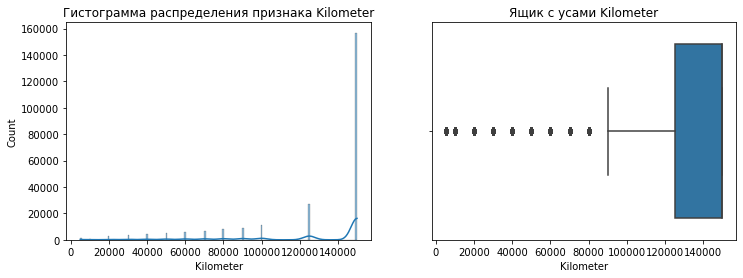

In [48]:
distribution_feature(df.Kilometer)

Распределение автомобилей по пробегу очень плохое, оно практически дискретное и ярко выраженной концентрацией возле 150 000 километров - почти 2/3 датасета с пробегом 150 000 км. В этом случае возникает вопрос о существенности влияния данного признака на определение цены в нашей модели. Интуитивно понятно, что цена зависит от пробега, но в условии, когда у 2/3 автомобилей пробег идентичен тезис, что цена зависит от пробега уже не такой однозначный в данном контексте.

Пока оставим как есть.

**Признак FuelType (тип топлива)**

In [49]:
df.FuelType.value_counts()

petrol            150509
gasoline           81032
missing values      6713
lpg                 3845
cng                  446
hybrid               171
other                 36
electric              30
Name: FuelType, dtype: int64

Тип потребляемого топлива (энергии) - это опция модели. Восстановить пропущенные значения по заданному правилу не реально. Количество объектов с пропущенными значениями невелико. Предлагаю удалить эти объекты, а также other.

In [50]:
df = df[df.FuelType != 'missing values']
df = df[df.FuelType != 'other']

Переведем значения данного признака в числовой формат, сделав справочник. Напишем функцию, которая переводит названия категорий в числа.

In [51]:
FuelType = pd.DataFrame(df.FuelType.unique(), columns = [df.FuelType.name])

def category(features, type_features):
    for i, item in enumerate(list(type_features[type_features.columns[0]])):
        df.loc[features == item, features.name] = i 
        
category(df.FuelType, FuelType)
df.FuelType = df.FuelType.astype('int')

df.FuelType.unique()

array([0, 1, 2, 3, 4, 5])

In [52]:
FuelType

,FuelType
0,gasoline
1,petrol
2,lpg
3,hybrid
4,cng
5,electric


**Признак NotRepaired (была машина в ремонте или нет)**

In [53]:
df.NotRepaired.value_counts()

no                191045
missing values     24089
yes                20899
Name: NotRepaired, dtype: int64

Довольно много людей не указывают данный факт. В этом случае пропущенное значение можно интерпретировать как третий вариант, когда неизвестен факт ремонта и исходя из этого модель даст оценку стоимости автомобиля. Если модель будет плохо считать, то удалим объекты с пропущенными значениями.

Переведем значения данного признака в числовой формат, сделав справочник

In [54]:
NotRepaired = pd.DataFrame(df.NotRepaired.unique(), columns = ['NotRepaired'])

category(df.NotRepaired, NotRepaired)
df.NotRepaired = df.NotRepaired.astype('int')

df.NotRepaired.unique()

array([0, 1, 2])

In [55]:
NotRepaired

,NotRepaired
0,missing values
1,no
2,yes


**Признак PostalCode (почтовый индекс продавца)**

In [56]:
df.PostalCode.value_counts()

10115    791
65428    419
60311    250
66333    219
38518    205
        ... 
12625      1
3119       1
89431      1
31719      1
86751      1
Name: PostalCode, Length: 8038, dtype: int64

Мы видим, что есть довольно высокая концентрация продавцов из определенных локаций определяемых почтовыми индексами. Не уверен в важности данного признака, но пока оставим.

**Признак NumberOfPictures (количество фотографий автомобиля)**

In [57]:
df.NumberOfPictures.value_counts()

0    236033
Name: NumberOfPictures, dtype: int64

Удаляем этот признак.

In [58]:
df = df.drop('NumberOfPictures', axis=1)

**Признаки Model и Brand (модель и марка автомобиля)**

Рассмотрим эти два признака одновременно, потому что наименования моделей разных марок не должны пересекаться. Проверим этот факт на практике. Для начала посмотрим чистоту заполненных значений  в данных признаках.

In [59]:
df.Brand.unique()

array(['jeep', 'volkswagen', 'skoda', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'bmw', 'seat', 'honda',
       'fiat', 'mini', 'smart', 'audi', 'subaru', 'volvo', 'mitsubishi',
       'opel', 'alfa_romeo', 'kia', 'hyundai', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'suzuki', 'chrysler',
       'rover', 'porsche', 'saab', 'daewoo', 'jaguar', 'land_rover',
       'lada'], dtype=object)

С марками автомобилей все хорошо. Посмотрим на модели в контексте конкретных марок.

In [60]:
model_brand = df.pivot_table(index=['Model'], columns=['Brand'], values=['Price'], fill_value=0)
model_brand[model_brand > 0] = 1
model_brand['total'] = model_brand.sum(axis=1)
model_brand[model_brand.total > 1]

Price                                                    \
Brand      alfa_romeo audi  bmw chevrolet chrysler citroen dacia daewoo   
Model                                                                     
1_reihe           0.0  0.0  0.0       0.0      0.0     0.0   0.0    0.0   
3_reihe           0.0  0.0  0.0       0.0      0.0     0.0   0.0    0.0   
5_reihe           0.0  0.0  0.0       0.0      0.0     0.0   0.0    0.0   
defender          0.0  0.0  0.0       0.0      0.0     0.0   0.0    0.0   
discovery         0.0  0.0  0.0       0.0      0.0     0.0   0.0    0.0   
freelander        0.0  0.0  0.0       0.0      0.0     0.0   0.0    0.0   
grand             0.0  0.0  0.0       0.0      1.0     0.0   0.0    0.0   
matiz             0.0  0.0  0.0       1.0      0.0     0.0   0.0    1.0   
other             1.0  1.0  1.0       1.0      1.0     1.0   1.0    1.0   

                          ...                                             \
Brand      daihatsu fiat  ... saab seat skoda smart subaru suzuki toyota   
Model                     ...                                              
1_reihe         0.0  0.0  ...  0.0  0.0   0.0   0.0    0.0    0.0    0.0   
3_reihe         0.0  0.0  ...  0.0  0.0   0.0   0.0    0.0    0.0    0.0   
5_reihe         0.0  0.0  ...  0.0  0.0   0.0   0.0    0.0    0.0    0.0   
defender        0.0  0.0  ...  0.0  0.0   0.0   0.0    0.0    0.0    0.0   
discovery       0.0  0.0  ...  0.0  0.0   0.0   0.0    0.0    0.0    0.0   
freelander      0.0  0.0  ...  0.0  0.0   0.0   0.0    0.0    0.0    0.0   
grand           0.0  0.0  ...  0.0  0.0   0.0   0.0    0.0    1.0    0.0   
matiz           0.0  0.0  ...  0.0  0.0   0.0   0.0    0.0    0.0    0.0   
other           1.0  1.0  ...  1.0  1.0   1.0   1.0    1.0    1.0    1.0   

                            total  
Brand      volkswagen volvo        
Model                              
1_reihe           0.0   0.0   2.0  
3_reihe           0.0   0.0   2.0  
5_reihe           0.0   0.0   2.0  
defender          0.0   0.0   2.0  
discovery         0.0   0.0   2.0  
freelander        0.0   0.0   2.0  
grand             0.0   0.0   3.0  
matiz             0.0   0.0   2.0  
other             1.0   1.0  38.0  

[9 rows x 39 columns]

Есть названия моделей, которые являются одинаковыми у разных брендов, а также есть огромный пласт объектов со значением 'other' у признака Model.

Посмотрим какие названия моделей пересекаются у брендов

In [61]:
model_duplicat = list(model_brand[model_brand.total > 1].index)
df[df.Model.isin(model_duplicat)][['Model', 'Brand']].drop_duplicates().sort_values('Model')

,Model,Brand
23229,1_reihe,mazda
764,1_reihe,peugeot
10,3_reihe,mazda
148,3_reihe,peugeot
1711,5_reihe,peugeot
337,5_reihe,mazda
269405,defender,rover
12953,defender,land_rover
4850,discovery,rover
2834,discovery,land_rover


1_reihe, 3_reihe и 5_reihe peugeot - это ошибка, т.к. это модели мазды.<br>
Бренды rover и land_rover - это одно и тоже.<br>
Модель matiz у chevrolet нет, она под маркой daewoo.<br>
У chrysler - grand voyager. У suzuki - grand vitara. У jeep - grand cherokee.<br>

Поправим эти названия в датасете.

In [62]:
df.loc[(df.Model == '1_reihe') & (df.Brand == 'peugeot'), 'Brand'] = 'mazda'
df.loc[(df.Model == '3_reihe') & (df.Brand == 'peugeot'), 'Brand'] = 'mazda'
df.loc[(df.Model == '5_reihe') & (df.Brand == 'peugeot'), 'Brand'] = 'mazda'

df.Brand = df.Brand.replace('rover', 'land_rover')

df.loc[(df.Model == 'matiz') & (df.Brand == 'chevrolet'), 'Brand'] = 'daewoo'
df.loc[(df.Model == 'grand') & (df.Brand == 'chrysler'), 'Model'] = 'grand_voyager'
df.loc[(df.Model == 'grand') & (df.Brand == 'suzuki'), 'Model'] = 'grand_vitara'
df.loc[(df.Model == 'grand') & (df.Brand == 'jeep'), 'Model'] = 'grand_cherokee'

Посмотрим какие цены и моделей other

In [63]:
pt = df[df.Model == 'other'].pivot_table(index=['Brand'], values='Price', aggfunc=['count', 'min', 'mean', 'max'])
pt.columns = ['count', 'min', 'mean', 'max']
pt['max-min'] = pt['max'] - pt['min']
pt.sort_values('count', ascending=False)

,count,min,mean,max,max-min
Brand,,,,,
citroen,1166,0,3207.103774,19900,19900
fiat,1097,0,3128.870556,20000,20000
mercedes_benz,925,0,9242.155676,20000,20000
hyundai,895,0,3210.929609,19900,19900
peugeot,811,0,4628.884094,19500,19500
ford,763,0,3915.461337,20000,20000
audi,746,0,9838.155496,20000,20000
mazda,713,0,2921.910238,15450,15450
suzuki,669,0,3165.491779,19000,19000


In [64]:
print('Количество объектов модели other =', pt['count'].sum())

Количество объектов модели other = 14029


Разброс большой по маркам. Other присутствует среди эконом класса, среднего класса и премиального класса. Кроме этого, наблюдается большой размах в ценах other внутри каждой марки. Оставим other как есть, т.к. если он присутствует в датасете, то значит это значение может выбрать проддавец при заполнении анкеты автомобиля.

Склеим признаки Model и Brand в один признак ModelBrand, а затем удалим признаки Model и Brand.

In [65]:
df['ModelBrand'] =  df.Brand + '_' + df.Model
df = df.drop(['Model', 'Brand'], axis=1)

Сделаем справочник для признака ModelBrand и переведем признак его в числовой формат

In [66]:
ModelBrand = pd.DataFrame(df.ModelBrand.unique(), columns = ['ModelBrand'])
category(df.ModelBrand, ModelBrand)
df.ModelBrand = df.ModelBrand.astype('int')

**Признак Price (целевой признак - цена автомобиля в евро)**

In [67]:
df.Price.describe()

count    236033.000000
mean       5311.435032
std        4726.106794
min           0.000000
25%        1600.000000
50%        3700.000000
75%        7790.000000
max       20000.000000
Name: Price, dtype: float64

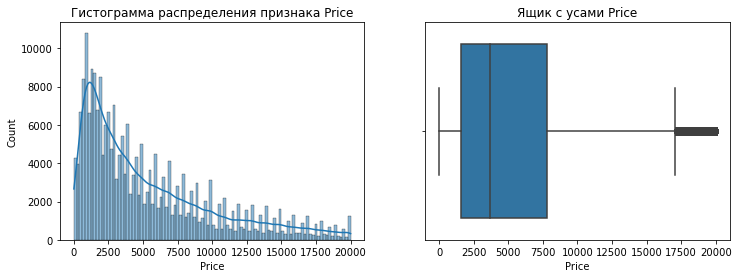

In [68]:
distribution_feature(df.Price)

Распределение цены на автомобили не похоже на нормальное распределение, которое ожидалось увидеть. Данное распределение больше похоже на распределение Пуассона и оно характеризует изменение среднего количества автомобилей при изменении цены в сторону возрастания. Длинный хвост с права на графике гистограммы и выбросы с права на boxplot, обясняют большое значение стандартного отклонения. <br>
Очень много объектов с нулевой или близкой к нулю ценой. Это ошибки заполнения и их надо удалить. Их нельзя заполнить средним или медианным значением, потому что у нас очень большой набор главных признаков - моделей (Model), а для каждой модели свои факторы цены и для каждого набора фактора цены будут свои средние и медианные значения.

В связи с выше перечисленным предлагаю удалить все объекты из нашего датасета, у которых цена будет меньше порога, который мы выберем. Выбор порога предлагаю выбрать из следующего списка - 5, 10, 15, 20 и 25 процентили.

In [69]:
print('5-я процентиль = ', df.Price.quantile(0.05))
print('10-я процентиль = ', df.Price.quantile(0.1))
print('15-я процентиль = ', df.Price.quantile(0.15))
print('20-я процентиль = ', df.Price.quantile(0.20))
print('25-я процентиль = ', df.Price.quantile(0.25))

5-я процентиль =  500.0
10-я процентиль =  800.0
15-я процентиль =  1000.0
20-я процентиль =  1300.0
25-я процентиль =  1600.0


Я думаю все, что меньше 500 евро - это автохлам или ошибка ввода и его цена - это цена металлолома и поэтому удалим все объявления с ценой меньше 500

In [70]:
df = df[df.Price >= 500]

**Проверка на корреляцию признаков**

In [71]:
df.corr()

,Price,Gearbox,Power,Kilometer,FuelType,NotRepaired,PostalCode,DaysLastSeen,AgeAutoMonth,CreatedInMonth,ModelBrand
Price,1.000000,0.252346,0.497931,-0.411935,-0.242666,-0.035594,0.058081,0.150770,-0.706780,0.014469,0.052693
Gearbox,0.252346,1.000000,0.432423,0.036021,-0.118375,0.005424,-0.042512,0.018096,-0.051694,-0.000034,0.003625
Power,0.497931,0.432423,1.000000,0.126717,-0.159770,0.012954,0.044400,0.053169,-0.115255,0.001677,0.072682
Kilometer,-0.411935,0.036021,0.126717,1.000000,-0.162278,0.004237,-0.011271,-0.076501,0.517447,-0.000877,-0.080472
FuelType,-0.242666,-0.118375,-0.159770,-0.162278,1.000000,-0.001741,-0.016830,0.012800,0.235069,0.002356,0.021742
NotRepaired,-0.035594,0.005424,0.012954,0.004237,-0.001741,1.000000,0.026904,-0.003459,-0.009211,0.001366,0.026507
PostalCode,0.058081,-0.042512,0.044400,-0.011271,-0.016830,0.026904,1.000000,0.022904,-0.034810,0.011665,-0.009766
DaysLastSeen,0.150770,0.018096,0.053169,-0.076501,0.012800,-0.003459,0.022904,1.000000,-0.094922,-0.365557,0.023972
AgeAutoMonth,-0.706780,-0.051694,-0.115255,0.517447,0.235069,-0.009211,-0.034810,-0.094922,1.000000,0.006507,-0.077487
CreatedInMonth,0.014469,-0.000034,0.001677,-0.000877,0.002356,0.001366,0.011665,-0.365557,0.006507,1.000000,0.000818


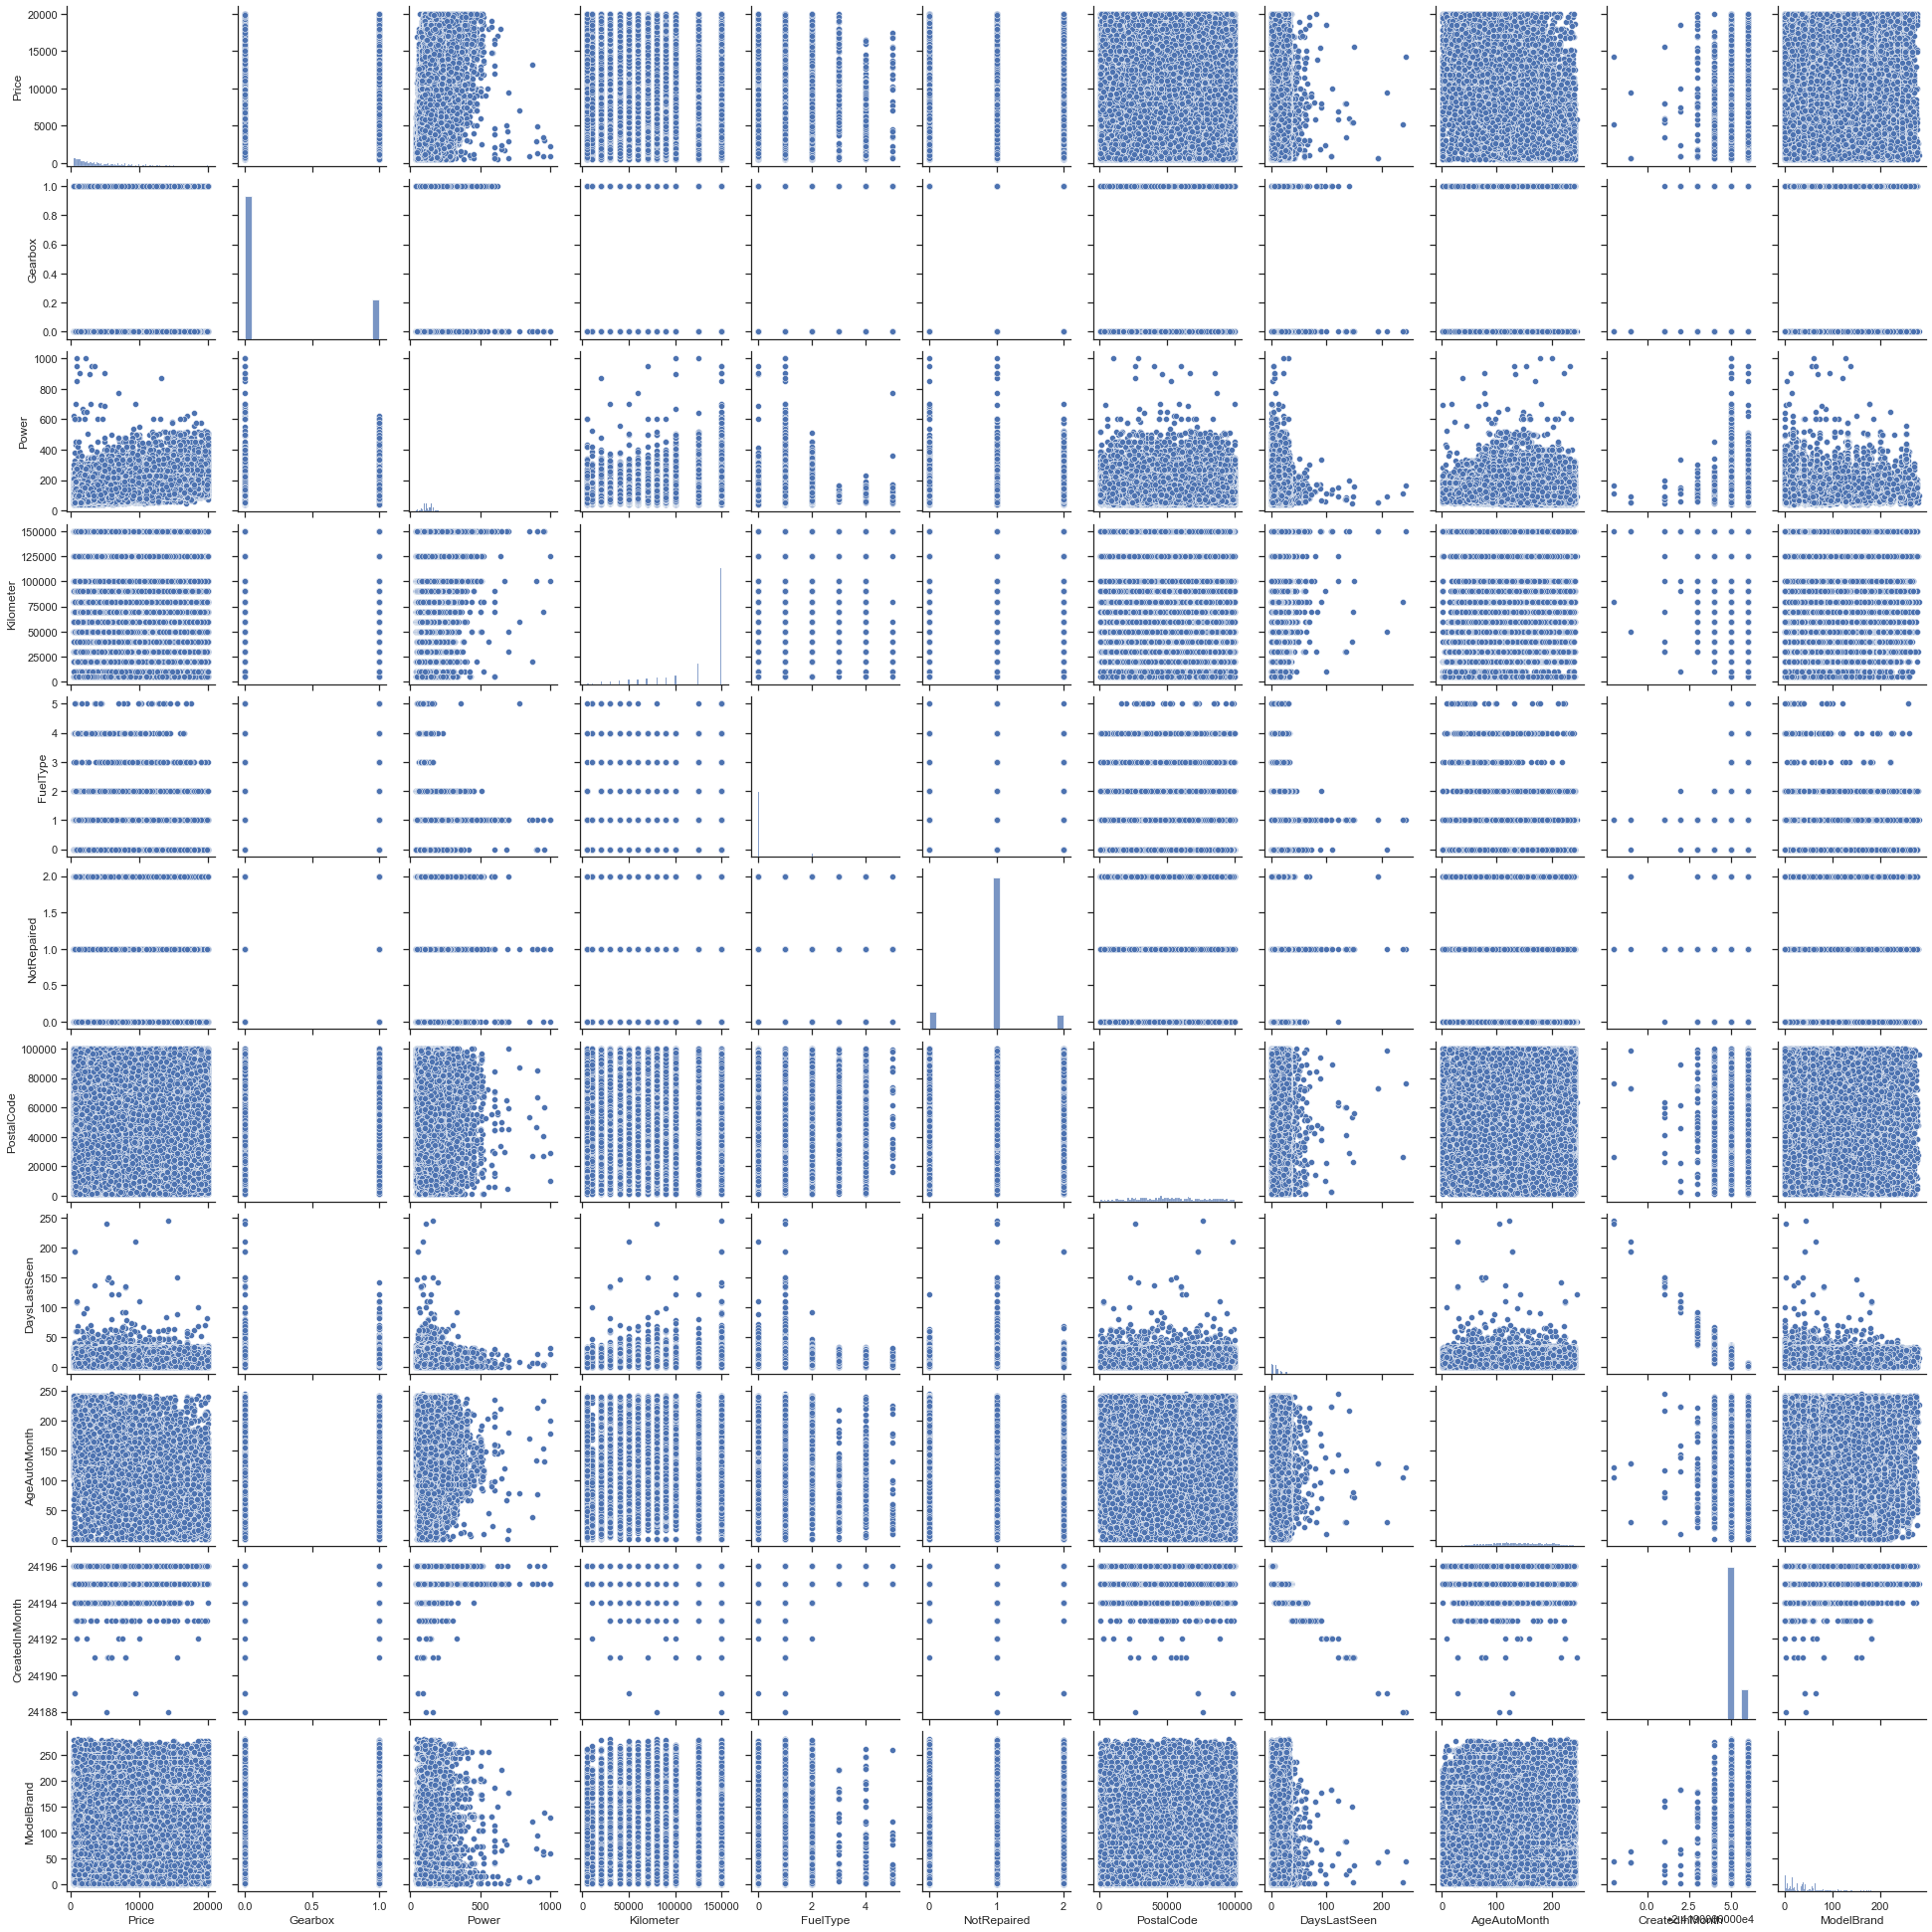

In [72]:
sns.set_theme(style="ticks")
sns.pairplot(df)

**Резюме.**<br>
В итоге мы удалили все аномальные и не относящиеся к обучению объекты и признаки.
При проверке на корреляцию наблюдаем умеренную и умеренно-сильную корреляцию цены (целевого признака) с признаками мощность двигателя и возраст автомобиля, а также слабую корреляцию с признаками типом коробки передач и типом топлива. Корреляция между нецелевыми признаками есть только между мощностью и типом коробки передач, но она скорее всего умеренная.<br>
Исходя из этого мы видим сильной влияющие (линейно) на цену признаки и слабо.
Будем считать, что обучающий датасет мы подготовили и задали правила преобразованния исходного датасета.

Итоговый датасет для обучения:

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225778 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   Price           225778 non-null  int64
 1   Gearbox         225778 non-null  int32
 2   Power           225778 non-null  int64
 3   Kilometer       225778 non-null  int64
 4   FuelType        225778 non-null  int32
 5   NotRepaired     225778 non-null  int32
 6   PostalCode      225778 non-null  int64
 7   DaysLastSeen    225778 non-null  int64
 8   AgeAutoMonth    225778 non-null  int64
 9   CreatedInMonth  225778 non-null  int64
 10  ModelBrand      225778 non-null  int32
dtypes: int32(4), int64(7)
memory usage: 25.3 MB


In [74]:
df.head(3)

,Price,Gearbox,Power,Kilometer,FuelType,NotRepaired,PostalCode,DaysLastSeen,AgeAutoMonth,CreatedInMonth,ModelBrand
2,9800,1,163,125000,0,0,90480,22,139,24195,0
3,1500,0,75,150000,1,1,91074,0,177,24195,1
4,3600,0,69,90000,0,1,60437,6,92,24195,2


Нормализуем данные и посчитаем обусловленность характеристической матрицы и собственные числа у нее.

In [75]:
df_train = df.copy()
numeric = ['Power', 'Kilometer', 'PostalCode', 'DaysLastSeen', 'AgeAutoMonth', 'CreatedInMonth', 'ModelBrand']

scaler = StandardScaler()
scaler.fit(df_train[numeric])
df_train[numeric] = scaler.transform(df_train[numeric])

Поделим наш датасет на таблицу признаков и целевых признаков:

In [92]:
X = df_train.drop('Price', axis=1).to_numpy()
y = df_train.Price.to_numpy()

Построим характеристическую матрицу признаков и найдем число обусловленности.

In [93]:
np.linalg.cond(X.transpose().dot(X)

12.707133759200586

Число обусловленности не около единицы, но и не сильно велико.

Посмотрим собтственные числа

In [94]:
np.round(np.linalg.eig(X.transpose().dot(X))[0])

array([ 29745.,  44083., 377974., 358411., 105017., 140769., 301011.,
       256495., 210391., 227636.])

Близких к нулю собственных числел нет у характеристической матрицы. Наименьшее влияние на целевой признак в нашем датасете окажут  признаки Gearbox	и Power, а наибольшее Kilometer и FuelType.

# 2. Обучите разные модели. Для каждой попробуйте различные гиперпараметры.

Перед тем как делить наш датасет на обучающую и тестовую выборку (валидационную выборку не буду выделять) обратимся к изначальной структуре датасета. Наш датасет был упорядочен по дате визита. Если я правильно понимаю, то во время визита продавец может изменить цену автомобиля, т.е. фактически дата последнего визита - это его последний офер по цене автомобиля. Если мы возьмем первые строчки нашего датасета (например 20%), то разделим наш датасет по времени и эти 20% будут как-бы прогнозом в будущее модели обученной на оставшейся 80% из точки разделения. Попробуем разделить наш датасет по предложенному выше принципу.

Делить будем подготовленную в результате предобработки выборку df и после разделения применим к ней нормирование StandardScaler. После обработки у нас осталось 225 778 объектов в датасете и 20% будет примерно 50 000 объектов.

In [79]:
df_test = df.iloc[:50_000, :].copy()
df_train = df.iloc[50_000:, :].copy()

Отмасштабируем числовые признаки.

In [80]:
numeric = ['Power', 'Kilometer', 'PostalCode', 'DaysLastSeen', 'AgeAutoMonth', 'CreatedInMonth', 'ModelBrand']

scaler = StandardScaler()
scaler.fit(df_train[numeric])
df_test[numeric] = scaler.transform(df_test[numeric])
df_train[numeric] = scaler.transform(df_train[numeric])

Сделаем нарезку на тестовые и обучающие выборки с выделением целевого признака.

In [81]:
X_train = df_train.drop('Price', axis=1)
X_test  = df_test.drop('Price', axis=1)
y_train = df_train['Price']
y_test = df_test['Price']

Напишем функцию подборщика моделей.

In [82]:
def grid_search(model, param):
    regr = GridSearchCV(model, 
                        param, 
                        scoring = 'neg_root_mean_squared_error',
                        cv = 3,
                        n_jobs = -1)
    search = regr.fit(X_train, y_train)    
    y_pred = search.best_estimator_.predict(X_test)
    return search.best_estimator_, mean_squared_error(y_test, y_pred)**0.5, r2_score(y_pred, y_test)


Найдем лучшую модель линейной регрессии с L1-регуляризацией

In [83]:
startTime = time.time()
# Параметры для подборщика
model_lasso = linear_model.Lasso(random_state=123)
param_lasso = {'alpha':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

# Подбор модели и расчет метрик для нее
lasso, rmse_lasso, r2_lasso = grid_search(model_lasso, param_lasso)
endTime = time.time()
time_lasso = endTime - startTime

print('Лучшая модель линейной регрессии с l1 регуляризацией =', lasso)
print('Метрика rmse =', rmse_lasso)
print('Метрика R2 =', r2_lasso)
print("Время, затраченное на обучение модели = ", round(time_lasso, 3))

Лучшая модель линейной регрессии с l1 регуляризацией = Lasso(alpha=0.01, random_state=123)
Метрика rmse = 2515.387620345736
Метрика R2 = 0.5980927362581037
Время, затраченное на обучение модели =  5.112


Найдем лучшую модель линейной регрессии с L2-регуляризацией

In [84]:
startTime = time.time()
# Параметры для подборщика
model_ridge = linear_model.Ridge(random_state=123)
param_ridge = {'alpha':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 20, 25, 50]}

# Подбор модели и расчет метрик для нее
ridge, rmse_ridge, r2_ridge = grid_search(model_ridge, param_ridge)
endTime = time.time()
time_ridge = endTime - startTime

print('Лучшая модель линейной регрессии с l2 регуляризацией =', ridge)
print('Метрика rmse =', rmse_ridge)
print('Метрика R2 =', r2_ridge)
print("Время, затраченное на обучение модели = ", round(time_ridge, 3))

Лучшая модель линейной регрессии с l2 регуляризацией = Ridge(alpha=25, random_state=123)
Метрика rmse = 2515.389614286371
Метрика R2 = 0.5980064804481775
Время, затраченное на обучение модели =  1.059


Найдем лучшую модель для случайного леса.

In [85]:
startTime = time.time()
# Параметры для подборщика
model_rfr = RandomForestRegressor(random_state=123)
param_rfr = {'n_estimators':[100], 
             'max_depth':[9]}

# Подбор модели и расчет метрик для нее
rfr, rmse_rfr, r2_rfr = grid_search(model_rfr, param_rfr)
endTime = time.time()
time_rfr = endTime - startTime

print('Лучшая модель регрессии случайный лес =', rfr)
print('Метрика rmse =', rmse_rfr)
print('Метрика R2 =', r2_rfr)
print("Время, затраченное на обучение модели = ", round((time_rfr), 3))

Лучшая модель регрессии случайный лес = RandomForestRegressor(max_depth=9, random_state=123)
Метрика rmse = 1902.0686352367175
Метрика R2 = 0.798587132170255
Время, затраченное на обучение модели =  119.461


Найдем лучшую модель для градиентного бустинга из sklearn.

In [86]:
startTime = time.time()
# Параметры для подборщика
model_gbr = GradientBoostingRegressor(random_state=123)
param_gbr = {'n_estimators':[100], 
             'max_depth':[2], 
             'learning_rate':[0.7]}

# Подбор модели и расчет метрик для нее
gbr, rmse_gbr, r2_gbr = grid_search(model_gbr, param_gbr)
endTime = time.time()
time_gbr = endTime - startTime

print('Лучшая модель регрессии случайный лес =', gbr)
print('Метрика rmse =', rmse_gbr)
print('Метрика R2 =', r2_gbr)
print("Время, затраченное на обучение модели = ", round(time_gbr, 3))

Лучшая модель регрессии случайный лес = GradientBoostingRegressor(learning_rate=0.7, max_depth=2, random_state=123)
Метрика rmse = 1809.060338309717
Метрика R2 = 0.8258323151348056
Время, затраченное на обучение модели =  44.354


Обучим модель для градиентного бустинга lightgbm

In [87]:
startTime = time.time()
model_lgb = lgb.LGBMRegressor(random_state=123)
param_lgb = {'objective': ['regression'], 
             'learning_rate': [0.9],
              'n_estimators': [10000],
              'max_depth': [2],
              'verbose_eval': [-1]} 

model_lgb, rmse_lgb, r2_lgb = grid_search(model_lgb, param_lgb)
endTime = time.time()
time_lgb = endTime - startTime

print('Лучшая модель регрессии градиентного бустинга lightgbm =', model_lgb)
print('Метрика rmse =', rmse_lgb)
print('Метрика R2 =', r2_lgb)
print("Время, затраченное на на обучение модели = ", round(time_lgb, 3))


[LightGBM] [Warning] Unknown parameter: verbose_eval
Лучшая модель регрессии градиентного бустинга lightgbm = LGBMRegressor(learning_rate=0.9, max_depth=2, n_estimators=10000,
              objective='regression', random_state=123, verbose_eval=-1)
Метрика rmse = 1495.3600026411084
Метрика R2 = 0.8881528306007065
Время, затраченное на на обучение модели =  218.191


Сделаем итоговую таблицу характеристик наших моделей

In [88]:
resume =[['lasso', rmse_lasso, r2_lasso, time_lasso, lasso],
         ['ridge', rmse_ridge, r2_ridge, time_ridge, ridge],
         ['random forrest', rmse_rfr, r2_rfr, time_rfr, rfr],
         ['gbr sklearn', rmse_gbr, r2_gbr, time_gbr, gbr],
         ['lightgbm', rmse_lgb, r2_lgb, time_lgb, model_lgb]]

resume = pd.DataFrame(resume, columns=['type_model', 'rmse', 'R2', 'time', 'model'])

Итоговая сравнительная таблица обучения моделей и результатов.

In [89]:
display(resume.sort_values('rmse'))

,type_model,rmse,R2,time,model
4,lightgbm,1495.360003,0.888153,218.190878,"LGBMRegressor(learning_rate=0.9, max_depth=2, ..."
3,gbr sklearn,1809.060338,0.825832,44.354352,([DecisionTreeRegressor(criterion='friedman_ms...
2,random forrest,1902.068635,0.798587,119.461366,"(DecisionTreeRegressor(max_depth=9, max_featur..."
0,lasso,2515.387620,0.598093,5.112154,"Lasso(alpha=0.01, random_state=123)"
1,ridge,2515.389614,0.598006,1.059399,"Ridge(alpha=25, random_state=123)"


Проанализируем скорость предсказания наших моделей по заданному объекту с заданным вектором признаков. Для каждого вектор признака проведем 1000 замеров времени получения предсказания модели и возьмем среднее значение по ним. В качестве объекта возьмем первый объект и тестовой выборки. Кроме времени выдачи предсказания замерим абсолютную и относительную точность.

In [92]:
anketa_test = df_test.iloc[0:1, 1:] # строку получим
price_anketa_test = df_test.iloc[0, 0]
test_time = []

for model in resume.model:
    average_time = []
    for _ in range(1000):
        startTime = time.time()
        price_pred = model.predict(anketa_test)[0]
        endTime = time.time()
        average_time.append(endTime - startTime)
    test_time.append([sum(average_time) / 1000, abs(price_pred - price_anketa_test), \
                      round(100 * abs(price_pred - price_anketa_test) / price_anketa_test)])
test_time = pd.DataFrame(test_time, 
                         columns=['average_time', 'abs delta', '% delta'],
                         index = resume.type_model)    
test_time.sort_values('average_time')

,average_time,abs delta,% delta
type_model,,,
ridge,0.001613,806.853468,8
lasso,0.001663,806.223024,8
gbr sklearn,0.001776,843.493588,9
lightgbm,0.004173,1331.381869,14
random forrest,0.014801,1631.587739,17


# Резюме:

На входе мы получили датасет не самого лучшего качества данных. <br>
В рамках предобработки данных я провел анализ данных и чистку данных в соответствии с логикой анализа данных.<br>
Датасет был разделен на обучающую и тестовую выборки относительно даты последнего визита. В тест были отобраны 20% объектов с самым ранней датой посещения для предсказания будущей цены, а в обучающую выборку попали остальные объекты - ретроспективная выборка.<br>
Через подборщик на обучающей выборке были обучены следующие типы моделей регрессий:
- линейная регрессия с l1-регуляризацией;
- линейная регрессия с l2-регуляризацией;
- случайный лес;
- градиентный бустинг из sklearn;
- градиентный бустинг lightgbm.<br>
В рамках обучения проводились замеры времени обучения и метрик rmse и R2.

Лучшая по метрикам оказалась модель lightgbm.
Лучшая по скорости обучения оказалась линейная регрессия. 
Лучшая по скорости предсказания оказалась модель ridge.

Таким образом, из тех моделей, которые мы обучили лучшей оказалась модель gbr sklearn.
Кроме этого, эта модель удовлетворяет минимальным требованиям rmse < 2500.